In [3]:
# External Dependencies
import os                          # Access system file-tree
import sys                         # Modify system parameters
from math import isclose           # isclose()
import numpy as np                 # Data structures
from optparse import OptionParser  # Get user input
import matplotlib.ticker as mticker  # Scientific notation in labels
from matplotlib.ticker import FuncFormatter

In [15]:
# Internal Dependencies
internalPath = os.getcwd() + "/../python"
print(internalPath)
sys.path.insert(0, internalPath)
from plotStyling import PlotStyling  # noqa: E402
from GSDUtil import GSDUtil  # noqa: E402

/home/aglisman/Dropbox/3_Brady_Lab/Code/potential-flow/bodies-in-potential-flow/jupyter_notebooks/../python


In [16]:
# Parameters
relative_path = os.getcwd() + "/../data/2021-08-26.01-15-39_collinear-swimmer-wall_varyZHeight"
output_dir = "figures"
output_dir = relative_path + "/" + output_dir + "/"
gsd_files = []
epsOutput = True

# Correctly get scientific notation in text elements
def scientific(x, pos):
    return '%0.2e' % x

scientific_formatter = FuncFormatter(scientific)
fmt = mticker.FuncFormatter(scientific_formatter)


In [20]:
# Load data from GSD

try:
    # Loop through all subdirectories in the 'data' directory
    for root, dirs, files in os.walk(relative_path, topdown=True):
        dirs.sort()
        files.sort()

        for file in files:  # Loop through all files in given directory
            if (".gsd" in file):
                with open(root + "/" + file) as g:
                    cur_gsd = GSDUtil(g.name, create_gsd=False)
                    gsd_files.append(cur_gsd)

    assert(len(gsd_files) > 0)

except:  # No files found
    raise IOError(
        f"Failure to load data. No files found in relPath {relative_path}")

In [21]:
# Load data into np structures

CoM_disp = np.zeros(len(gsd_files), dtype=np.double)
R_avg = np.zeros_like(CoM_disp, dtype=np.double)
Z_height = np.zeros_like(CoM_disp, dtype=np.double)
phaseShift = np.zeros_like(CoM_disp, dtype=np.double)
U0 = np.zeros_like(CoM_disp, dtype=np.double)
omega = np.zeros_like(CoM_disp, dtype=np.double)
epsilon = np.zeros_like(CoM_disp, dtype=np.double)
final_t = np.zeros_like(CoM_disp, dtype=np.double)

for i in range(len(gsd_files)):

    # Data from final frame
    gsd_files[i].snapshot = gsd_files[i].trajectory.read_frame(
        gsd_files[i].trajectory.file.nframes - 1)
    final_t[i] = gsd_files[i].snapshot.log['integrator/t']
    CoM_disp_comp = gsd_files[i].snapshot.log['particles/double_position'][1]

    # Data from initial frame (not 0)
    gsd_files[i].snapshot = gsd_files[i].trajectory.read_frame(1)
    R_avg[i] = gsd_files[i].snapshot.log['swimmer/R_avg']
    Z_height[i] = gsd_files[i].snapshot.log['swimmer/Z_height']
    phaseShift[i] = gsd_files[i].snapshot.log['swimmer/phase_shift']
    U0[i] = gsd_files[i].snapshot.log['swimmer/U0']
    omega[i] = gsd_files[i].snapshot.log['swimmer/omega']
    epsilon[i] = U0[i] / R_avg[i] / omega[i]
    CoM_disp_comp -= gsd_files[i].snapshot.log['particles/double_position'][1]

    CoM_disp[i] = np.linalg.norm(CoM_disp_comp)

In [23]:

# NOTE: Assuming each GSD has same number of frames
nframes = gsd_files[0].trajectory.file.nframes

In [35]:
# ANCHOR: Orientation vector
q = np.zeros((len(gsd_files), 3, nframes - 2), dtype=np.double)
time = np.zeros((len(gsd_files), nframes - 2), dtype=np.double)

for i in range(len(gsd_files)):  # loop over all GSD files

    gsd_current = gsd_files[i]
    q_current = np.zeros((3, nframes - 2), dtype=np.double)

    for j in range(1, nframes - 1):  # loop over all frames in GSD file

        snapshot_current = gsd_current.trajectory.read_frame(j)

        q_current[:, j - 1] = snapshot_current.log['particles/double_position'][0] - \
            snapshot_current.log['particles/double_position'][2]
        time[i, j - 1] = snapshot_current.log['integrator/t']

    q_current = np.linalg.norm(q_current, axis=0)

    q[i, :, :] = q_current

q0 = q[:, :, 0]

In [34]:
# ANCHOR: Angular orientational displacement

theta = np.zeros((len(gsd_files), nframes - 2), dtype=np.double)

for i in range(len(gsd_files)):

    theta[i, :] = np.dot(q0[i, :].reshape(1, 3), q[i, :, :])

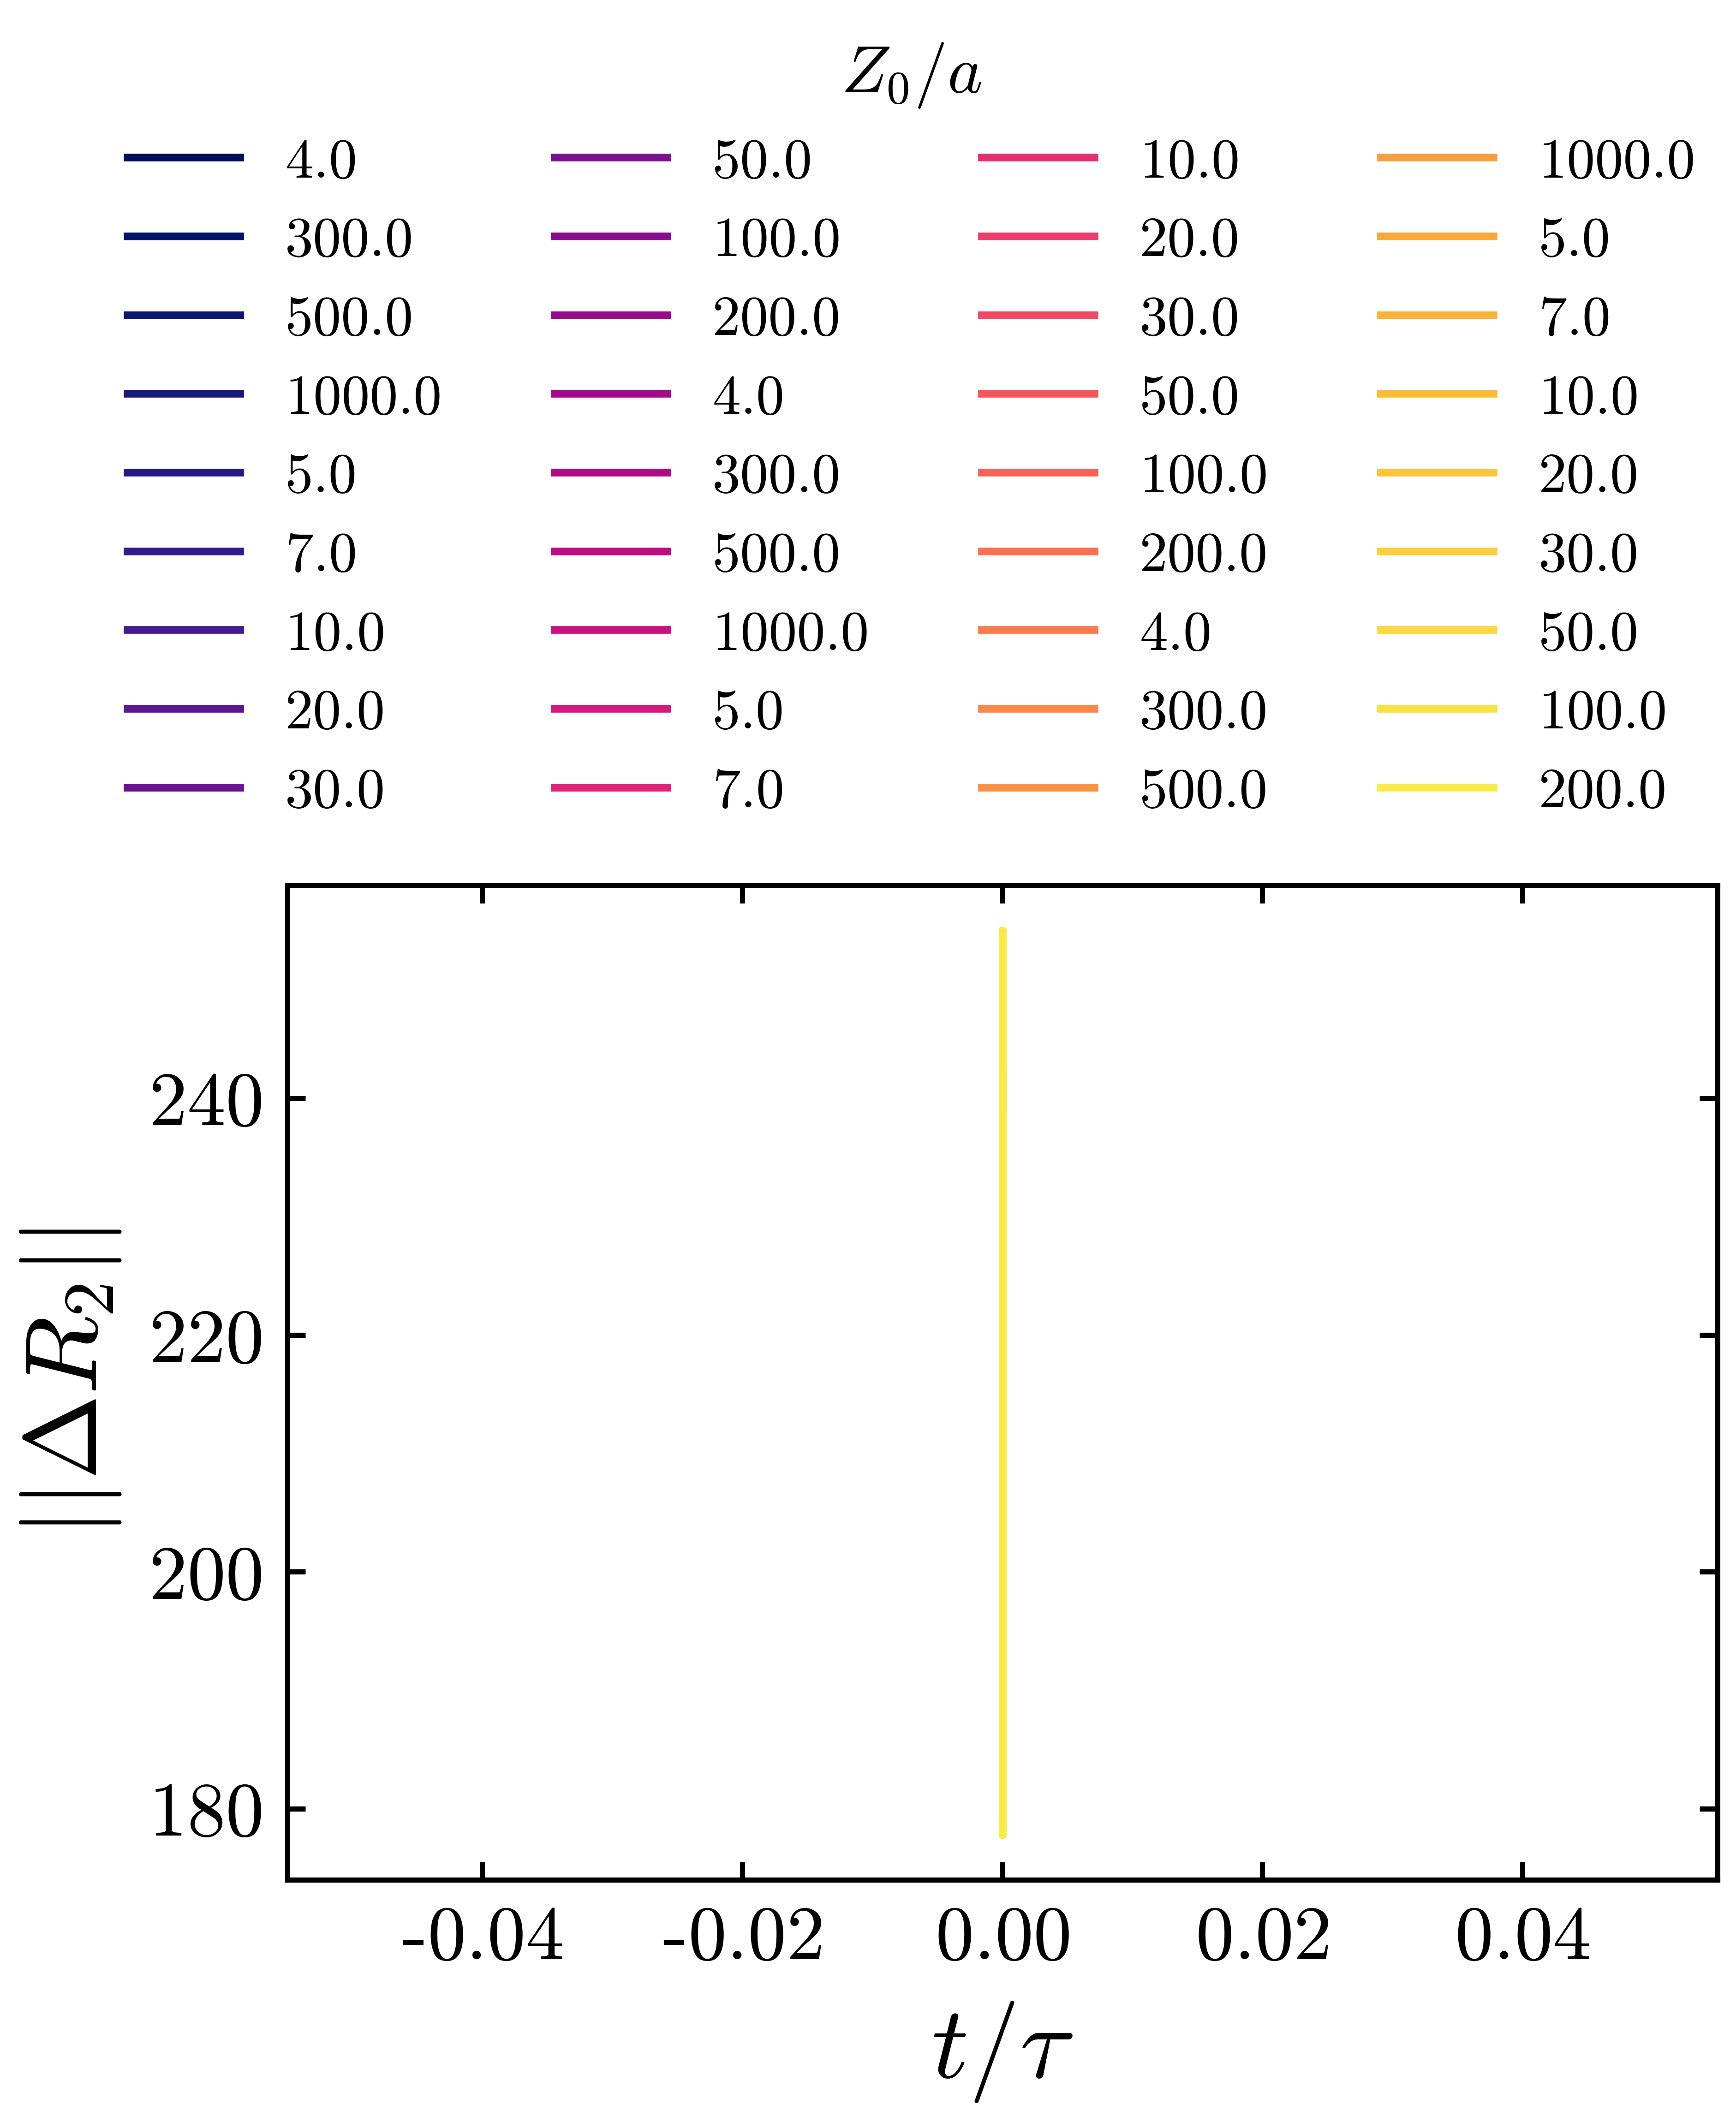

In [50]:
# PLOT: Angular orientaional dynamics

# PLOT: Locater point position (x-axis)
numLines = len(gsd_files)
orientDyn_Plot = PlotStyling(numLines,
                          r"$t/\tau$", r"$|| \Delta R_2 ||$",
                          title=None, loglog=False,
                          outputDir=output_dir, figName="loc-pos-x", eps=epsOutput,
                          continuousColors=True)
# Show numerical data points
orientDyn_Plot.make_plot(showPlot=True)

for i in range(len(gsd_files)):
    orientDyn_Plot.curve(time[i, :], theta[i, :], zorder=i, label=f"{Z_height[i]}")

orientDyn_Plot.legend(title=r"$Z_0/a$",
    loc='best', ncol=4, bbox_to_anchor=(0.12, 1.0, 0.9, 0.9))
orientDyn_Plot.fig